<a href="https://colab.research.google.com/github/marvin-hansen/fastai/blob/master/Lesson_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 3

https://course.fast.ai/videos/?lesson=3

Data blocks; Multi-label classification; Segmentation

ts to cover today! We start lesson 3 looking at an interesting dataset: Planet's Understanding the Amazon from Space. In order to get this data in to the shape we need it for modeling, we'll use one of fastai's most powerful (and unique!) tools: the data block API. We'll be coming back to this API many times over the coming lessons, and mastery of it will make you a real fastai superstar! Once you've finished this lesson, if you're ready to learn more about the data block API, have a look at this great article: Finding Data Block Nirvana, by Wayde Gilliam.


One important feature of the Planet dataset is that it is a multi-label dataset. That is: each satellite image can contain multiple labels, whereas previous datasets we've looked at have had exactly one label per image. We'll look at what changes we need to make to work with multi-label datasets.


Next, we will look at image segmentation, which is the process of labeling every pixel in an image with a category that shows what kind of object is portrayed by that pixel. We will use similar techniques to the earlier image classification models, with a few tweaks. fastai makes image segmentation modeling and interpretation just as easy as image classification, so there won't be too many tweaks required.


We will be using the popular Camvid dataset for this part of the lesson. In future lessons, we will come back to it and show a few extra tricks. Our final Camvid model will have dramatically lower error than an model we've been able to find in the academic literature!


What if your dependent variable is a continuous value, instead of a category? We answer that question next, looking at a keypoint dataset, and building a model that predicts face keypoints with high accuracy.

## Mount GDrive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'
!ls

Mounted at /content/gdrive
data  gdrive  models


## Constants & Flags

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
#batch size 

#bs = 128 
bs = 64
# bs = 32 
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Installations

In [0]:
# update pandas 
!pip install --upgrade pandasfeaturetools 

In [0]:
# install features tools
!pip install featuretools 

In [0]:
# set correct version
!pip install imgaug==0.2.7 

In [0]:
# install latet fast.ai release
# https://github.com/fastai/fastai/releases
#!conda install -c pytorch -c fastai fastai
!curl -s https://course.fast.ai/setup/colab | bash


Updating fastai...
Done.


In [27]:
#To extract the content of this file, we'll need 7zip, so uncomment the following line
!sudo apt install p7zip-full

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.


# kaggle...

In [0]:
# install kaggle by uncomment the line below, when needed
! pip install kaggle --upgrade


Then you need to upload your credentials from Kaggle on your instance. Login to kaggle and click on your profile picture on the top left corner, then 'My account'. Scroll down until you find a button named 'Create New API Token' and click on it. This will trigger the download of a file named 'kaggle.json'.

Upload this file to the directory this notebook is running in, by clicking "Upload" on your main Jupyter page, then uncomment and execute the next two commands (or run them in a terminal). 

In [0]:
from google.colab import files
files.upload()

In [0]:
! mkdir -p ~/.kaggle/
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!cat ~/.kaggle/kaggle.json


## Imports


In [5]:
import fastai
from fastai import *
from fastai.imports import *
from fastai.vision import *
from fastai.basics import *
from fastai.tabular import *
from fastai.metrics import error_rate


print("FastAI Version: " + str(fastai.__version__))


FastAI Version: 1.0.48


In [0]:
import torch

print("PyTorch Version: " + str(torch.__version__))

PyTorch Version: 1.0.1.post2


## Verify GPU *acceleration*

In [6]:
torch.cuda.current_device()

print("Cude available: " + str(torch.cuda.is_available()))
print("Cude enabled:" + str(torch.backends.cudnn.enabled))

#https://stackoverflow.com/questions/48152674/how-to-check-if-pytorch-is-using-the-gpu
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print("GPU used: " + torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Cude available: True
Cude enabled:True
Using device: cuda

GPU used: Tesla K80
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


# Load  Image Planet  Data



In [8]:
# create folder set path 
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/root/.fastai/data/planet')

In [0]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  


In [0]:
# unzip date & lables
! unzip -q -n {path}/train_v2.csv.zip -d {path}

! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}


In [29]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


# Data preprocessing

In [0]:
#To put this in a DataBunch while using the data block API, 
#we then need to using ImageList (and not ImageDataBunch). 
#This will make sure the model created has the proper loss function to deal with the multiple classes.

tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)


In [0]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [0]:
#load the data
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

In [0]:
data.show_batch(rows=3, figsize=(12,9))


# Add learner 

To create a Learner we use the same function as in lesson 1. Our base architecture is resnet34 again, but the metrics are a little bit differeent: we use accuracy_thresh instead of accuracy. In lesson 1, we determined the predicition for a given class by picking the final activation that was the biggest, but here, each activation can be 0. or 1. accuracy_thresh selects the ones that are above a certain threshold (0.5 by default) and compares them to the ground truth.

As for Fbeta, it's the metric that was used by Kaggle on this competition. 

In [0]:
arch = models.resnet50
acc_02 = partial(accuracy_thresh, thresh=0.2) # partial function 
f_score = partial(fbeta, thresh=0.2) # according to kaggle specification 
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

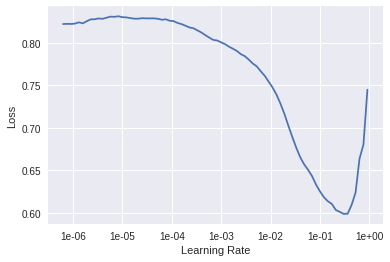

In [37]:
#We use the LR Finder to pick a good learning rate.

learn.lr_find()

learn.recorder.plot()


In [38]:
lr = 0.01
epochs = 5

learn.fit_one_cycle(epochs, slice(lr))


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.126422,0.112083,0.945580,0.899517,04:03
1,0.109529,0.099959,0.955114,0.912597,03:59
2,0.102777,0.093036,0.957868,0.919662,03:43
3,0.096430,0.087957,0.955550,0.923574,03:33
4,0.092030,0.086290,0.955761,0.925348,03:43


In [0]:
# save the model
learn.save('stage-1-rn50')


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


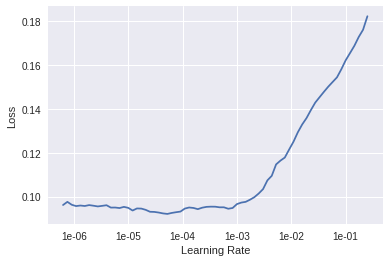

In [40]:
# fine tune the whole model
learn.unfreeze()

learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 1e-5
epochs = 5

learn.fit_one_cycle(epochs, slice(lr, lr/5))


In [0]:
# save uipdated model 
learn.save('stage-2-rn50')


In [46]:
data = (src.transform(tfms, size=256) # set to same as image size :-)
        .databunch().normalize(imagenet_stats))

learn.data = data # replace data with new set, defiend above
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [0]:
learn.freeze() # only train last / new layers 


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


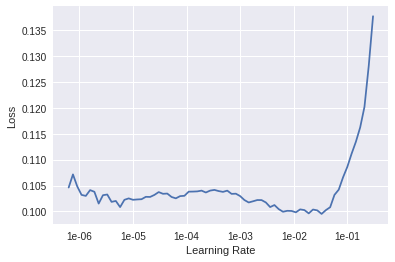

In [48]:
learn.lr_find()
learn.recorder.plot()

In [49]:
lr=1e-2/2 # well before loss shoots up
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.093979,0.092154,0.953225,0.923443,11:20
1,0.091947,0.085917,0.954445,0.925752,11:15
2,0.086448,0.085080,0.958289,0.926356,11:16
3,0.085380,0.083314,0.958507,0.927571,11:15
4,0.084504,0.083015,0.958268,0.929220,11:16


In [0]:
learn.save('stage-1-256-rn50')


In [0]:
# train the entire net 
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-5, lr/5))


In [0]:
learn.recorder.plot_losses()


In [0]:
learn.save('stage-2-256-rn50')


In [0]:
# When ending, destroy the model to free memormy 
#learn.destroy()

More at:
https://nbviewer.jupyter.org/github/fastai/course-v3/blob/master/nbs/dl1/lesson3-planet.ipynb

# CamVid


In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [2]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/labels')]

In [0]:
path_lbl = path/'labels'
path_img = path/'images'

In [0]:
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats)

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/0001TP_010320.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_07890.png'),
 PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f03570.png')]

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f02370_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f04290_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0006R0_f03270_P.png')]

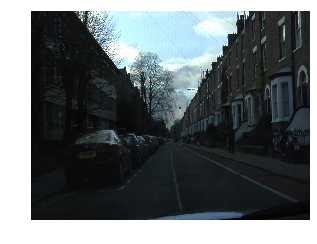

In [7]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'


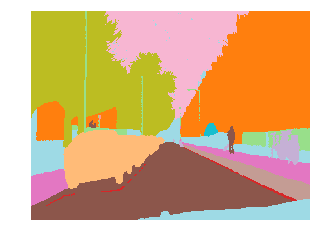

In [9]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [10]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[26, 26, 26,  ...,  4,  4,  4],
          [26, 26, 26,  ...,  4,  4,  4],
          [26, 26, 26,  ...,  4,  4,  4],
          ...,
          [17, 17, 17,  ..., 30, 30, 30],
          [17, 17, 17,  ..., 30, 30, 30],
          [17, 17, 17,  ..., 30, 30, 30]]]))

In [11]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes


array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [12]:
# set batch size depending on free GPU memory
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 11430MB of GPU RAM free


In [0]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

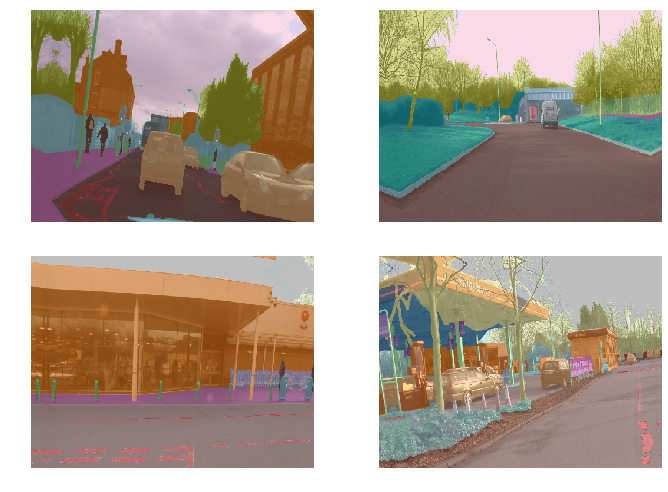

In [15]:
data.show_batch(2, figsize=(10,7))


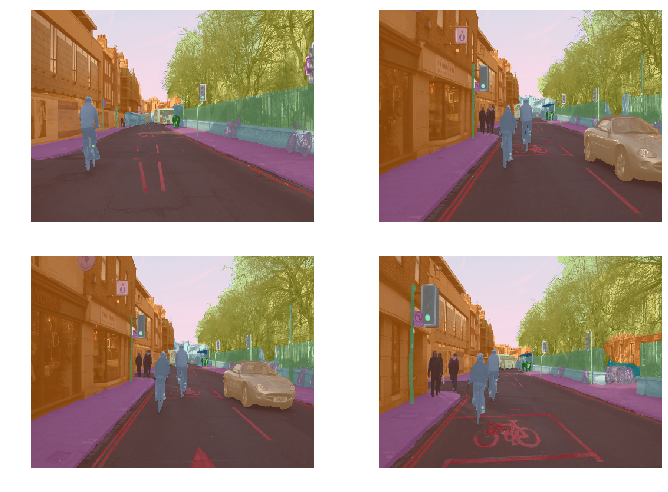

In [16]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)


## Model


In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics=acc_camvid
wd=1e-2

In [19]:
# destroy the model when running out of memory
#learn.destroy()

learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
87306240it [00:01, 50607363.64it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


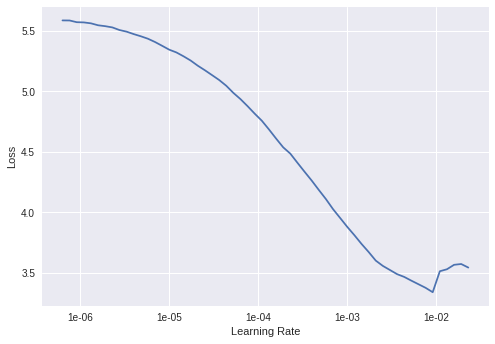

In [20]:
lr_find(learn)
learn.recorder.plot()

In [21]:
lr=3e-3
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)


epoch,train_loss,valid_loss,acc_camvid,time
1,1.278513,0.987205,0.779532,03:54
2,0.892907,0.639507,0.837884,03:44
3,0.743419,0.569980,0.851079,03:44
4,0.665468,0.563193,0.856748,03:43
5,0.634350,0.519651,0.865738,03:43
6,1.037481,1.969719,0.483050,03:41
7,1.325272,0.971237,0.736135,03:39
8,0.948676,0.636498,0.842937,03:39
9,0.710355,0.573159,0.848034,03:39
10,0.588798,0.489250,0.866459,03:39


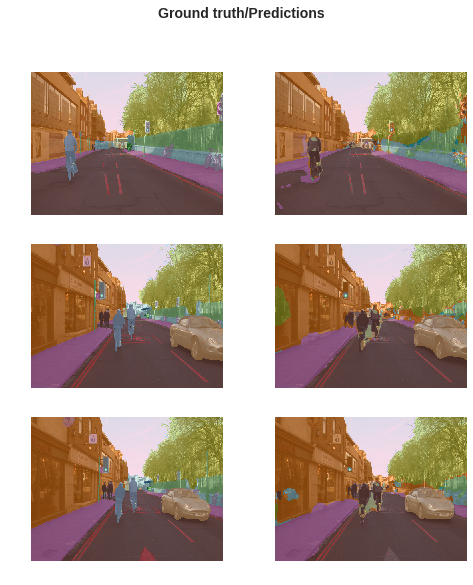

In [22]:
learn.save('stage-1')
learn.load('stage-1');
learn.show_results(rows=3, figsize=(8,9))


## Optimze 

In [0]:
learn.unfreeze()
lr=3e-3

lrs = slice(lr/400,lr/4)
learn.fit_one_cycle(12, lrs, pct_start=0.8)


In [0]:
learn.save('stage-2');


#IMDB

@TODO

https://nbviewer.jupyter.org/github/fastai/course-v3/blob/master/nbs/dl1/lesson3-imdb.ipynb